In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import gym
import scipy.signal

Mounted at /content/drive


In [19]:
seed = 543
np.random.seed(seed=seed)
env = gym.make("CartPole-v1")
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

/content/drive/My Drive/Colab Notebooks/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/content/drive/My Drive/Colab Notebooks/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [3]:
def discounted_cumulative_sums(x, discount):
    '''
    :param array(n) x: reward
    :param float discount
    '''
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [15]:
class Buffer:
    def __init__(self, observation_dimensions, size, gamma=0.99):
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.gamma = gamma
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward):
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.pointer += 1

    def finish_trajectory(self):
        path_slice = slice(self.trajectory_start_index, self.pointer)

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            self.reward_buffer[path_slice], self.gamma
        )
        self.advantage_buffer[path_slice] -= np.mean(self.advantage_buffer[path_slice])
        self.trajectory_start_index = self.pointer

    def get(self):
        return (
            self.observation_buffer[:self.pointer],
            self.action_buffer[:self.pointer],
            self.advantage_buffer[:self.pointer],
        )
    
    def clear(self):
        self.pointer, self.trajectory_start_index = 0, 0

buffer = Buffer(observation_dimensions, 4000)

In [8]:
def mlp(x, sizes, activation='relu', output_activation=None):
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

In [20]:
def logprobabilities(logits, a):
    '''
    :param array(n, num_actions) logits: model output
    :param array(n) a
    :return array(n) logprobability
    '''
    logprobabilities_all = tf.math.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability

In [10]:
@tf.function
def sample_action(observation):
    '''
    :param array(n, 4) observation
    :return array(1) action
    '''
    logits = model(tf.expand_dims(observation, axis=0))
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return action[0]

In [21]:
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, [64, 64, num_actions])
model = keras.Model(inputs=observation_input, outputs=logits)
optimizer = keras.optimizers.Adam()

In [13]:
def train_model(observation_buffer, action_buffer, advantage_buffer):
    '''
    :param array(n, observation_dimensions) observation_buffer
    :param array(n) action_buffer
    :param array(n) advantage_buffer
    '''
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(
            logprobabilities(model(observation_buffer), action_buffer) * advantage_buffer
        )
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [22]:
epochs = 1000
sum_reward_one_step = np.zeros(epochs)

for epoch in range(epochs):
    buffer.clear()
    sum_reward = 0
    observation = env.reset()

    while 1:
        action = int(sample_action(observation))
        observation_new, reward, done, _ = env.step(action)
        sum_reward += reward

        buffer.store(observation, action, reward)

        observation = observation_new

        if done:
            break

    buffer.finish_trajectory()
    
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
    ) = buffer.get()

    loss = -train_model(observation_buffer, action_buffer, advantage_buffer)

    sum_reward_one_step[epoch] = sum_reward

    if tf.math.is_nan(loss):
        print(
            f" Find NaN at Epoch: {epoch}. Reward: {sum_reward}"
        )
        break
    
    if epoch % 10 == 0:
        print(
            f" Epoch: {epoch}. Reward: {sum_reward}"
        )

 Epoch: 0. Reward: 13.0
 Epoch: 10. Reward: 12.0
 Epoch: 20. Reward: 16.0
 Epoch: 30. Reward: 18.0
 Epoch: 40. Reward: 12.0
 Epoch: 50. Reward: 74.0
 Epoch: 60. Reward: 15.0
 Epoch: 70. Reward: 8.0
 Epoch: 80. Reward: 31.0
 Epoch: 90. Reward: 24.0
 Epoch: 100. Reward: 32.0
 Epoch: 110. Reward: 15.0
 Epoch: 120. Reward: 20.0
 Epoch: 130. Reward: 10.0
 Epoch: 140. Reward: 18.0
 Epoch: 150. Reward: 11.0
 Epoch: 160. Reward: 16.0
 Epoch: 170. Reward: 24.0
 Epoch: 180. Reward: 34.0
 Epoch: 190. Reward: 15.0
 Epoch: 200. Reward: 31.0
 Epoch: 210. Reward: 18.0
 Epoch: 220. Reward: 18.0
 Epoch: 230. Reward: 15.0
 Epoch: 240. Reward: 9.0
 Epoch: 250. Reward: 19.0
 Epoch: 260. Reward: 12.0
 Epoch: 270. Reward: 17.0
 Epoch: 280. Reward: 15.0
 Epoch: 290. Reward: 65.0
 Epoch: 300. Reward: 11.0
 Epoch: 310. Reward: 24.0
 Epoch: 320. Reward: 36.0
 Epoch: 330. Reward: 29.0
 Epoch: 340. Reward: 16.0
 Epoch: 350. Reward: 18.0
 Epoch: 360. Reward: 24.0
 Epoch: 370. Reward: 14.0
 Epoch: 380. Reward: 33.0

In [25]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=5537.5156>

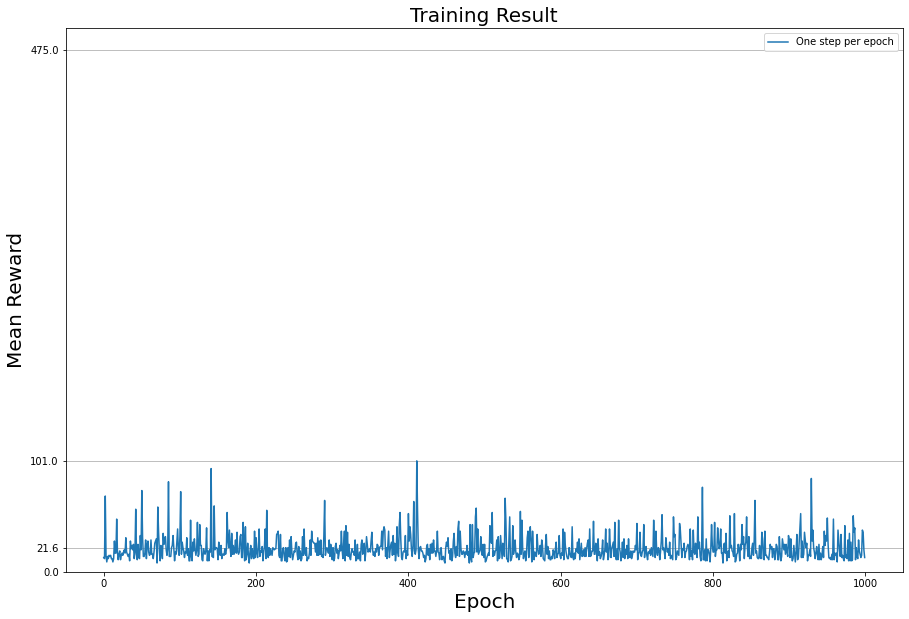

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.plot(np.arange(0, epochs), sum_reward_one_step, label='One step per epoch')

plt.xlabel('Epoch', fontsize=20) 
plt.ylabel('Mean Reward', fontsize=20)
plt.title("Training Result", fontsize=20)

plt.ylim(0, env.spec.reward_threshold+20)
plt.yticks([0, np.mean(sum_reward_one_step), np.max(sum_reward_one_step), env.spec.reward_threshold])
plt.grid(axis='y')
plt.legend()

plt.show()

In [ ]:
from gym.wrappers import RecordVideo
record_env = RecordVideo(env, './video')

current_state = record_env.reset()
sum_reward = 0
while 1:
    action = int(sample_action(current_state))
    next_state, reward, done, info = record_env.step(action)
    sum_reward += reward
    current_state = next_state
    if done:
        break

record_env.close()
print(sum_reward)

/content/drive/My Drive/Colab Notebooks/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/content/drive/My Drive/Colab Notebooks/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/content/drive/My Drive/Colab Notebooks/

13.0
